In [1]:
from utils.analysis.tools import simDir, springPhaseDiagram
from pathlib import Path
from utils.file_operations import input_parse
from tqdm import tqdm
import multiprocessing as mp 
from pathlib import Path
from utils import plot
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib as mpl
from utils.plot import _FIGURE_DIR, get_size_inches
from typing import List, Optional

root = Path("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/04_CoupledFlow/")

In [2]:
no_condensate = simDir("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/04_CoupledFlow/20240118_RNAOnly/M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_0.1_c1_3.53_sw_1.0_sr_2.5_cn_5.5_l_6_M3_1.0_kt_0.0_rl_9.0_wd_0.0")
no_condensate.run()
no_condensate.rna()
no_condensate_rna = no_condensate.rna_amount[-1]

In [3]:
class springPhaseDiagram:
    def __init__(self,
                 directory: str,
                 sweep_file: str = "sweep_parameters.txt",
                 sweep_parameters: Optional[List[str]] = None):
        self.sweep_directory = Path(directory)
        self.sweep_file = self.sweep_directory / sweep_file
        self.sweep_parameters = sweep_parameters or self._load_sweep_parameters()

    def extract_data(self,frame):
        simdir_paths = [file.parent for file in self.sweep_directory.glob("./*/input_params.txt")]
        processes = mp.Pool(8-1)
        self.results = processes.map(self.worker,[(path,frame) for path in simdir_paths])
        self.df = pd.DataFrame(self.results)
        if 'rest_length' in self.df.columns:
            self.df.loc[:, "rest_length"] = self.df["rest_length"].apply(lambda x: eval(x)[0]).astype(np.float64)
        self.df.loc[:, "k_tilde"] = self.df["k_tilde"].astype(np.float64)
    
    def worker(self,worker_input):
        simdir_path, frame = worker_input
        sim = simDir(simdir_path)
        relevant_params = {parameter: str(sim.params[parameter]) for parameter in self.sweep_parameters}
        sim.run(); sim.rna(); sim.condensate()
        return relevant_params | {"rna_amount": sim.rna_amount.flatten()[frame],
                                "condensate_com": sim.com[frame,0],
                                "aspect_ratio": sim.aspect_ratio[frame],
                                "mask": sim.xy[sim.mask[frame,:],:],
                                "concentration": sim.concentration_profile[0][frame,:][sim.mask[frame,:]]}

    def extract_enhancer_loci(self,frame):
        simdir_paths = [file.parent for file in self.sweep_directory.glob("./*/input_params.txt")]
        processes = mp.Pool(8-1)
        self.enhancer_loci = processes.map(self.enhancer_worker,[(path,frame) for path in simdir_paths])

    def enhancer_worker(self,worker_input):
        simdir_path, frame = worker_input
        simdir_path = Path(simdir_path)
        sim = simDir(simdir_path.as_posix())
        param_values = sim.params
        relevant_params = {parameter: str(param_values[parameter]) for parameter in self.sweep_parameters}
        df = pd.read_csv(simdir_path/"stats.txt",sep=r"\t")
        return relevant_params | {"enhancer_locus": df["well_center_x"].iloc[frame]}

In [4]:
spd = springPhaseDiagram(root/"20240702_PhaseDiagramSpringVsRestLengthCondensateMovesSeed_Longer",
                         sweep_parameters=["k_tilde","rest_length"])
spd.extract_data(-1)
spd.df.to_pickle("20240702_PhaseDiagramSpringVsRestLengthCondensateMovesSeed.pkl")


Start.Start.Start. Start. Start.Start.  Start.   Start. Start. Start. Start.Start.  Start. Start. Start. Start. Start. Start. Start. Start.Start.  Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start.Start.  Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start.

In [6]:
spd.df[spd.df["rest_length"] == 8]

,k_tilde,rest_length,rna_amount,condensate_com,aspect_ratio,mask,concentration
3,0.316228,8.0,14.064724,7.360790,1.154186,"[[4.7844298753849035, 1.5492747149330341], [5....","[4.369772, 4.5888863, 4.4869924, 4.2696385, 4...."
13,0.562341,8.0,14.030896,7.552983,1.125000,"[[4.7844298753849035, 1.5492747149330341], [5....","[4.282416, 4.5721855, 4.451381, 4.148722, 4.49..."
157,1.0,8.0,14.020492,7.621858,1.116517,"[[4.7844298753849035, 1.5492747149330341], [5....","[4.240889, 4.564379, 4.432761, 4.0966597, 4.48..."
191,1.77828,8.0,14.015694,7.659780,1.115481,"[[4.7844298753849035, 1.5492747149330341], [5....","[4.2186756, 4.5602255, 4.422303, 4.070069, 4.4..."
238,0.01,8.0,16.870230,0.698015,1.061057,"[[3.5520189880328754, 2.5914057194641402], [2....","[4.037465, 4.1196322, 4.0704527, 4.4806614, 4...."
239,0.017783,8.0,16.739069,1.201086,1.137406,"[[3.5520189880328754, 2.5914057194641402], [2....","[4.330113, 4.287443, 4.170969, 4.4234924, 4.36..."
240,0.031623,8.0,16.415531,2.081640,1.335585,"[[3.5520189880328754, 2.5914057194641402], [2....","[4.491572, 4.3166957, 4.6620607, 4.6308923, 4...."
241,0.056234,8.0,15.927087,3.270370,1.649038,"[[3.5520189880328754, 2.5914057194641402], [4....","[4.3410683, 4.75655, 4.54654, 4.626488, 4.9159..."
242,0.1,8.0,15.592452,4.173441,1.862317,"[[3.5520189880328754, 2.5914057194641402], [4....","[4.008924, 4.5748796, 4.3680735, 4.4610157, 4...."
243,0.177828,8.0,15.424627,4.692888,1.974015,"[[4.7844298753849035, 1.5492747149330341], [3....","[4.4799166, 4.212703, 4.348111, 4.6788597, 4.0..."


In [6]:
def generate_linlog_sequence(min_value, max_value):
    if min_value <= 0 or max_value <= 0:
        raise ValueError("min_value and max_value must be positive")

    sequence = []

    # Start from the smallest power of 10 less than or equal to min_value
    min_power = int(np.floor(np.log10(min_value)))
    max_power = int(np.ceil(np.log10(max_value)))

    for power in range(min_power, max_power + 1):
        # For each power of 10, generate linear sequence
        start = max(10 ** power, min_value)
        end = min(10 ** (power + 1) - 1, max_value)
        sequence.extend(np.arange(start, end + 1, 10 ** power))

    return np.array(sequence)
def map_y(y):
    return (np.log(y) - y_min) / (y_max - y_min) * (len(pivot.index) - 1)+0.5


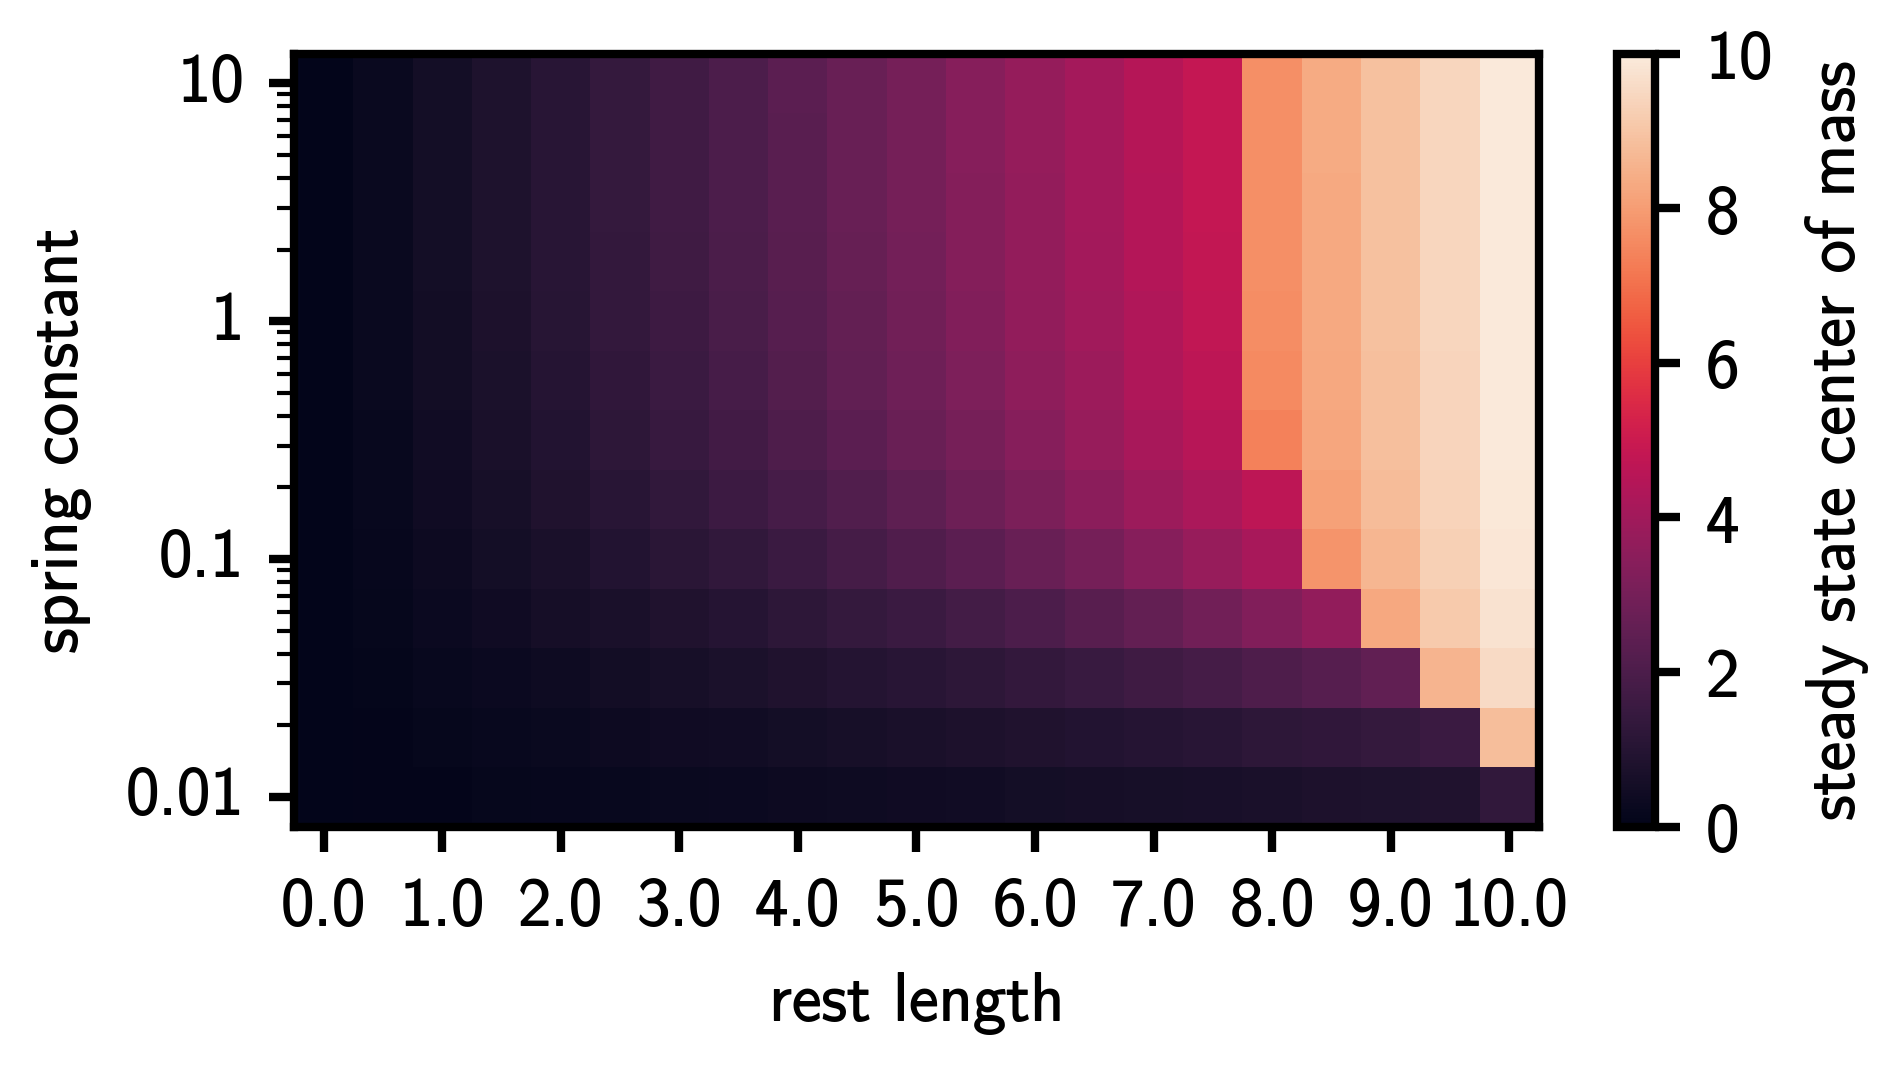

In [6]:
variable="condensate_com"
xlabel="rest length"
ylabel="spring constant"
cbarlabel="steady state center of mass"

fig, ax = plt.subplots()
scale = 0.7
fig.set_size_inches(get_size_inches(1,2/4))
pivot = spd.df.pivot(index="k_tilde",columns="rest_length",values=variable)
sns.heatmap(pivot, ax = ax,
            cbar_kws={'label': cbarlabel},
            cmap="rocket",
            vmin=0,
            vmax=10)
ax.invert_yaxis()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

x_min, x_max = pivot.columns.min(), pivot.columns.max()
y_min, y_max = np.log(pivot.index.min()), np.log(pivot.index.max())
ax.yaxis.set_minor_locator(ticker.FixedLocator(map_y(generate_linlog_sequence(0.01,10))))
ax.set_yticks(map_y(np.array([0.01,0.1,1,10])))
# ax.set_yticklabels([f"$10^{{{i}}}$" for i in [-2,-1,0,1]])
ax.set_yticklabels([10**i for i in [-2,-1,0,1]])
for spine in ax.spines:
    ax.spines[spine].set_visible(True)
cb = ax.collections[0].colorbar
cb.outline.set_color('black')
cb.outline.set_linewidth(1)
plt.savefig(_FIGURE_DIR / "Fig2_C_CondensatePosition")

In [7]:
c_white_trans = mpl.colors.colorConverter.to_rgba('white',alpha = 0)
c_white= mpl.colors.colorConverter.to_rgba('white',alpha = 1)
c_black_trans = mpl.colors.colorConverter.to_rgba('black',alpha = 0)
c_black= mpl.colors.colorConverter.to_rgba('black',alpha = 1)
cmap_black = mpl.colors.LinearSegmentedColormap.from_list('rb_cmap',[c_black_trans,c_black],512)
cmap = mpl.colors.LinearSegmentedColormap.from_list('rb_cmap',[c_white_trans,c_white],512)
def shape(xy,c,ax,cmap=cmap):
    x = xy[:,0]
    y = xy[:,1]
    ax.tricontourf(x,y,c,cmap=cmap)
    ax.set_aspect(1)
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
        ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)

In [8]:
mask_pivot = spd.df.pivot(index="k_tilde",columns="rest_length",values=["mask","concentration","condensate_com","k_tilde","rest_length"])
mask_pivot = mask_pivot.iloc[::-1]

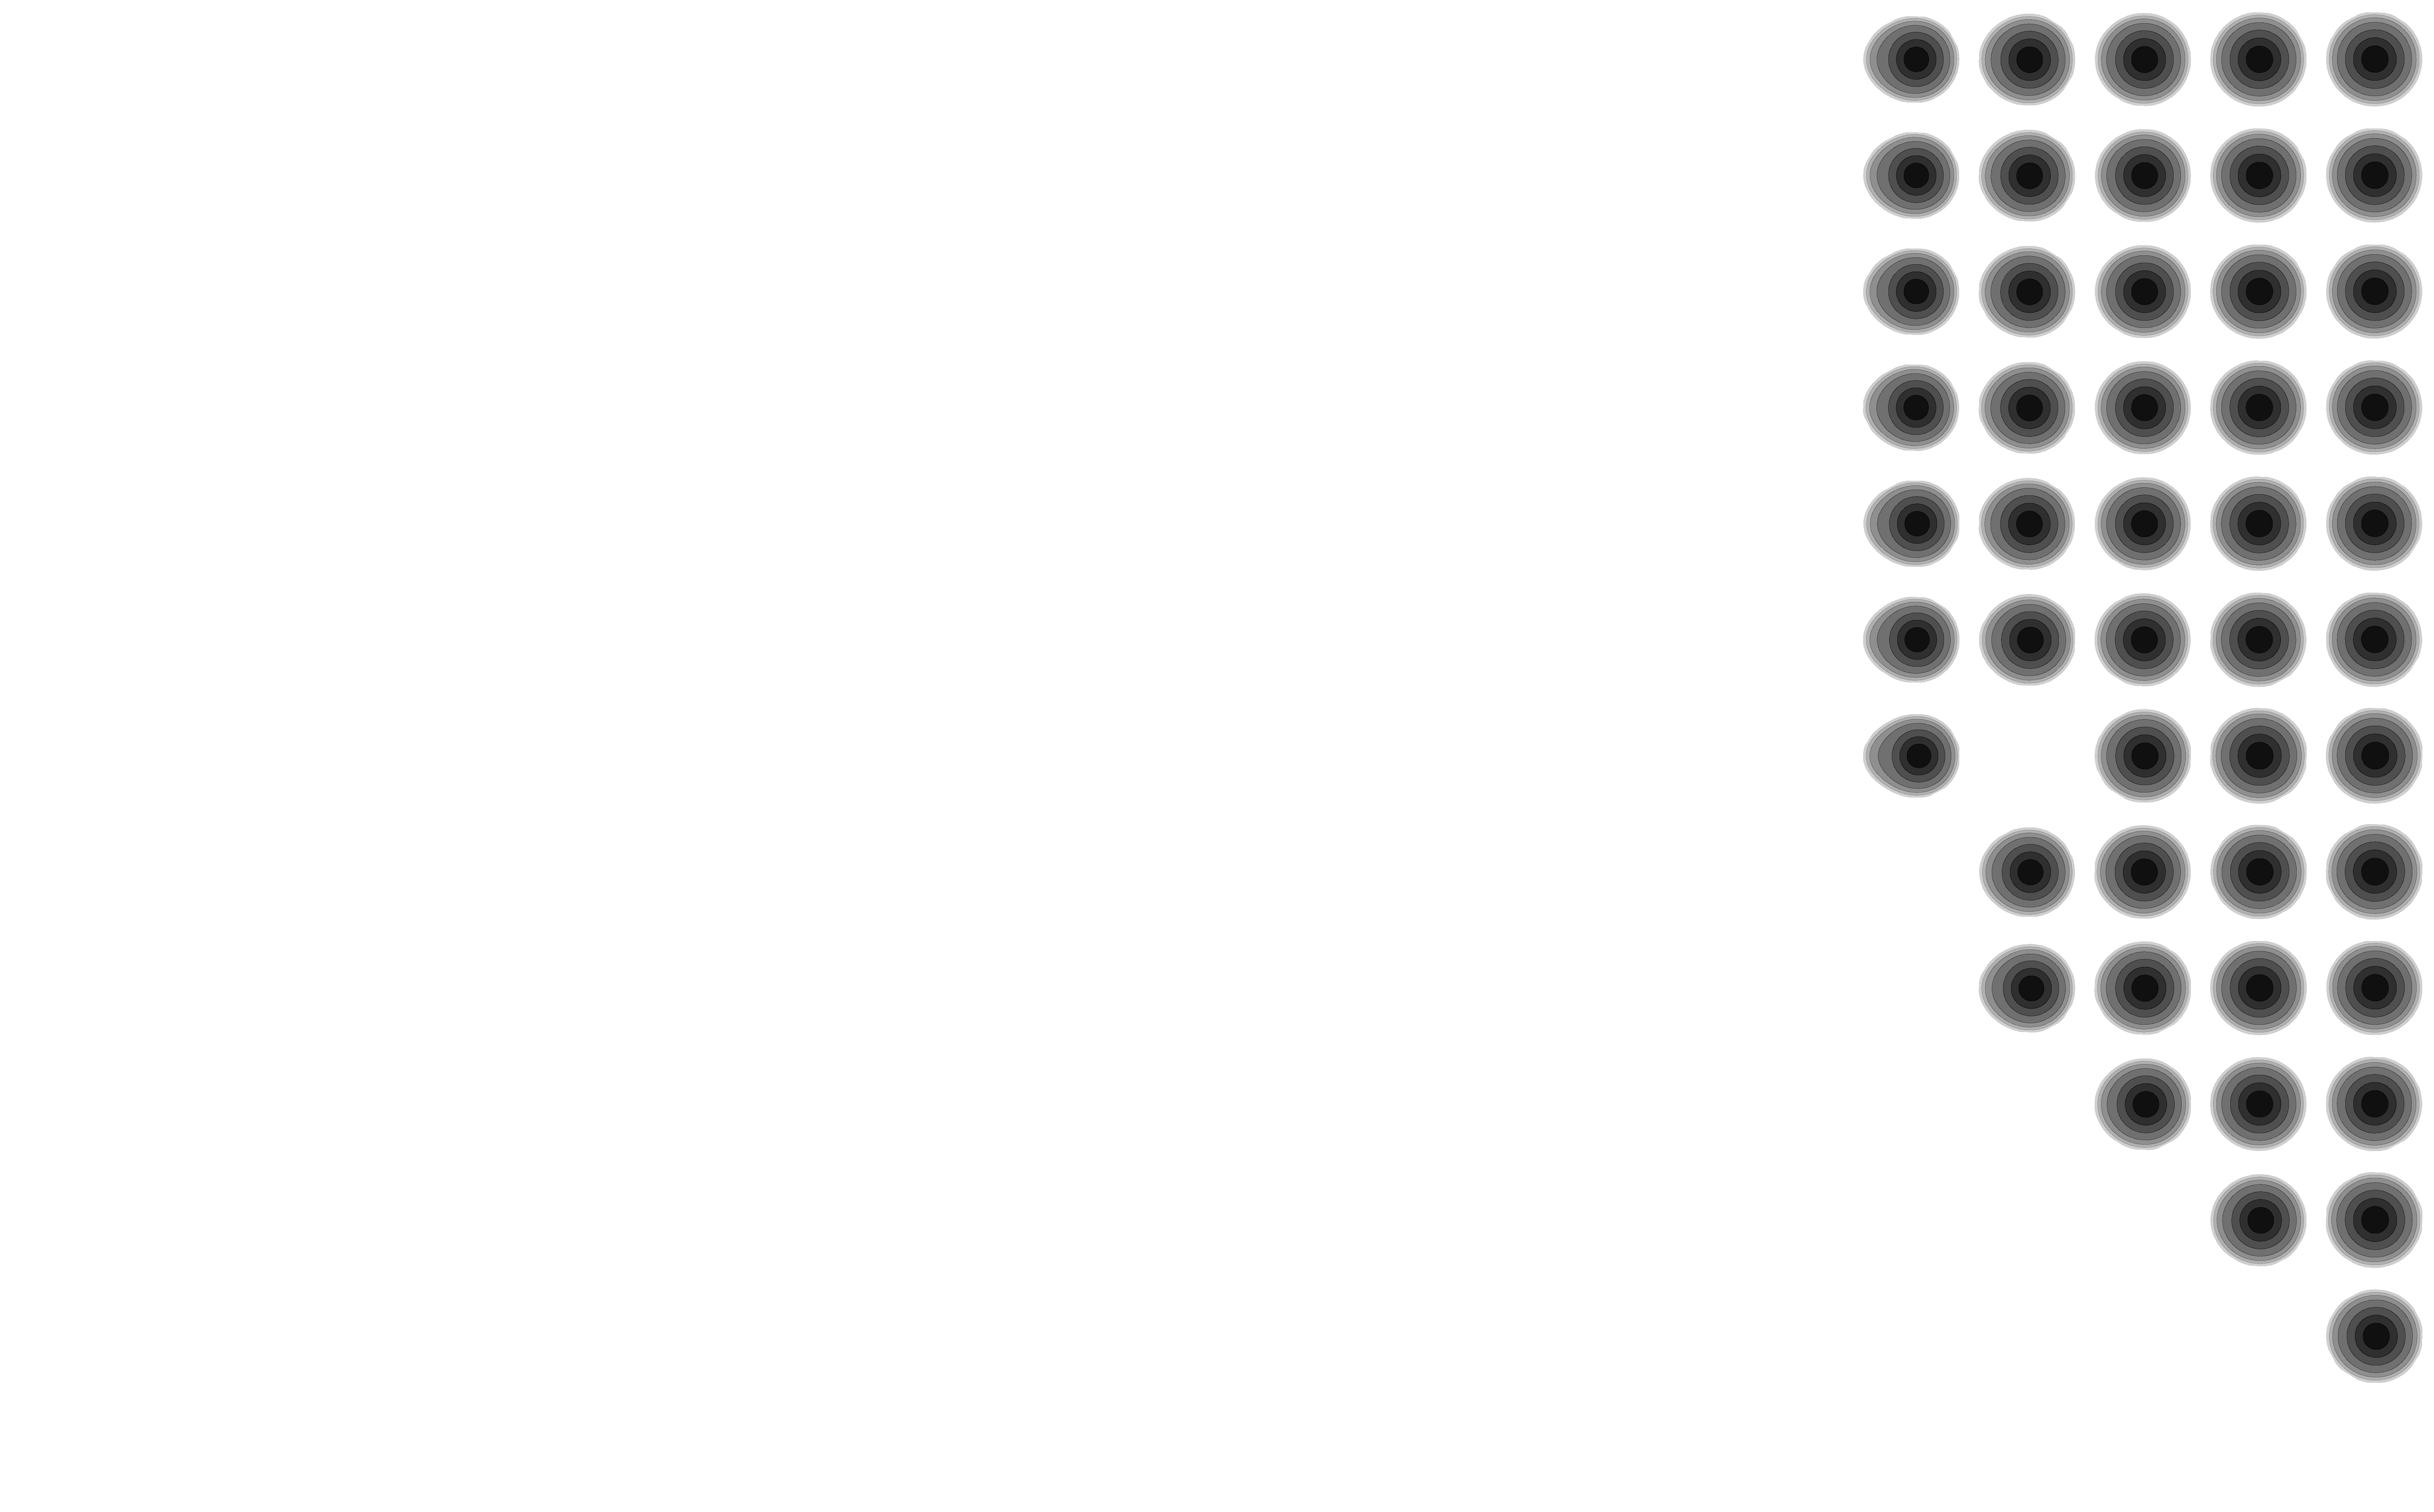

In [12]:
fig,axes=plt.subplots(len(mask_pivot["mask"].index),len(mask_pivot["mask"].columns))
cm_in_inch = 2.54
fig.set_size_inches(5.29*cm_in_inch, 3.29*cm_in_inch)
for ax,arr_xy,arr_c,com,k_tilde,rest_length in zip(axes.flatten(),
                           mask_pivot["mask",].to_numpy().flatten(),
                           mask_pivot["concentration",].to_numpy().flatten(),
                           mask_pivot["condensate_com",].to_numpy().flatten(),
                           mask_pivot["k_tilde",].to_numpy().flatten(),
                           mask_pivot["rest_length",].to_numpy().flatten()):
    if not (k_tilde == 0.316228 and rest_length in [3.5, 7.5, 8.5]):
        if com > 5:
            shape(arr_xy,arr_c,ax,cmap_black)
        else:
            shape(arr_xy,arr_c,ax,cmap)
    else:
        for spine in ax.spines:
            ax.spines[spine].set_visible(False)
            ax.tick_params(
            axis='both',
            which='both',
            bottom=False,
            left=False,
            labelbottom=False,
            labelleft=False)
plt.savefig(_FIGURE_DIR / "Fig2_C_Mask")

In [4]:
spd = springPhaseDiagram(root/"20240218_PhaseDiagramSpringVsRestLengthCondensateMovesSeedHighRes_Longer",
                         sweep_parameters=["k_tilde","rest_length"])
spd.extract_data(-1)
spd.df.to_pickle("20240218_PhaseDiagramSpringVsRestLengthCondensateMovesSeedHighRes_Longer.pkl")
# spd.df = pd.read_pickle("20240218_PhaseDiagramSpringVsRestLengthCondensateMovesSeedHighRes.pkl")

Start.Start.Start. Start.Start.Start.  Start.    Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start. Start.

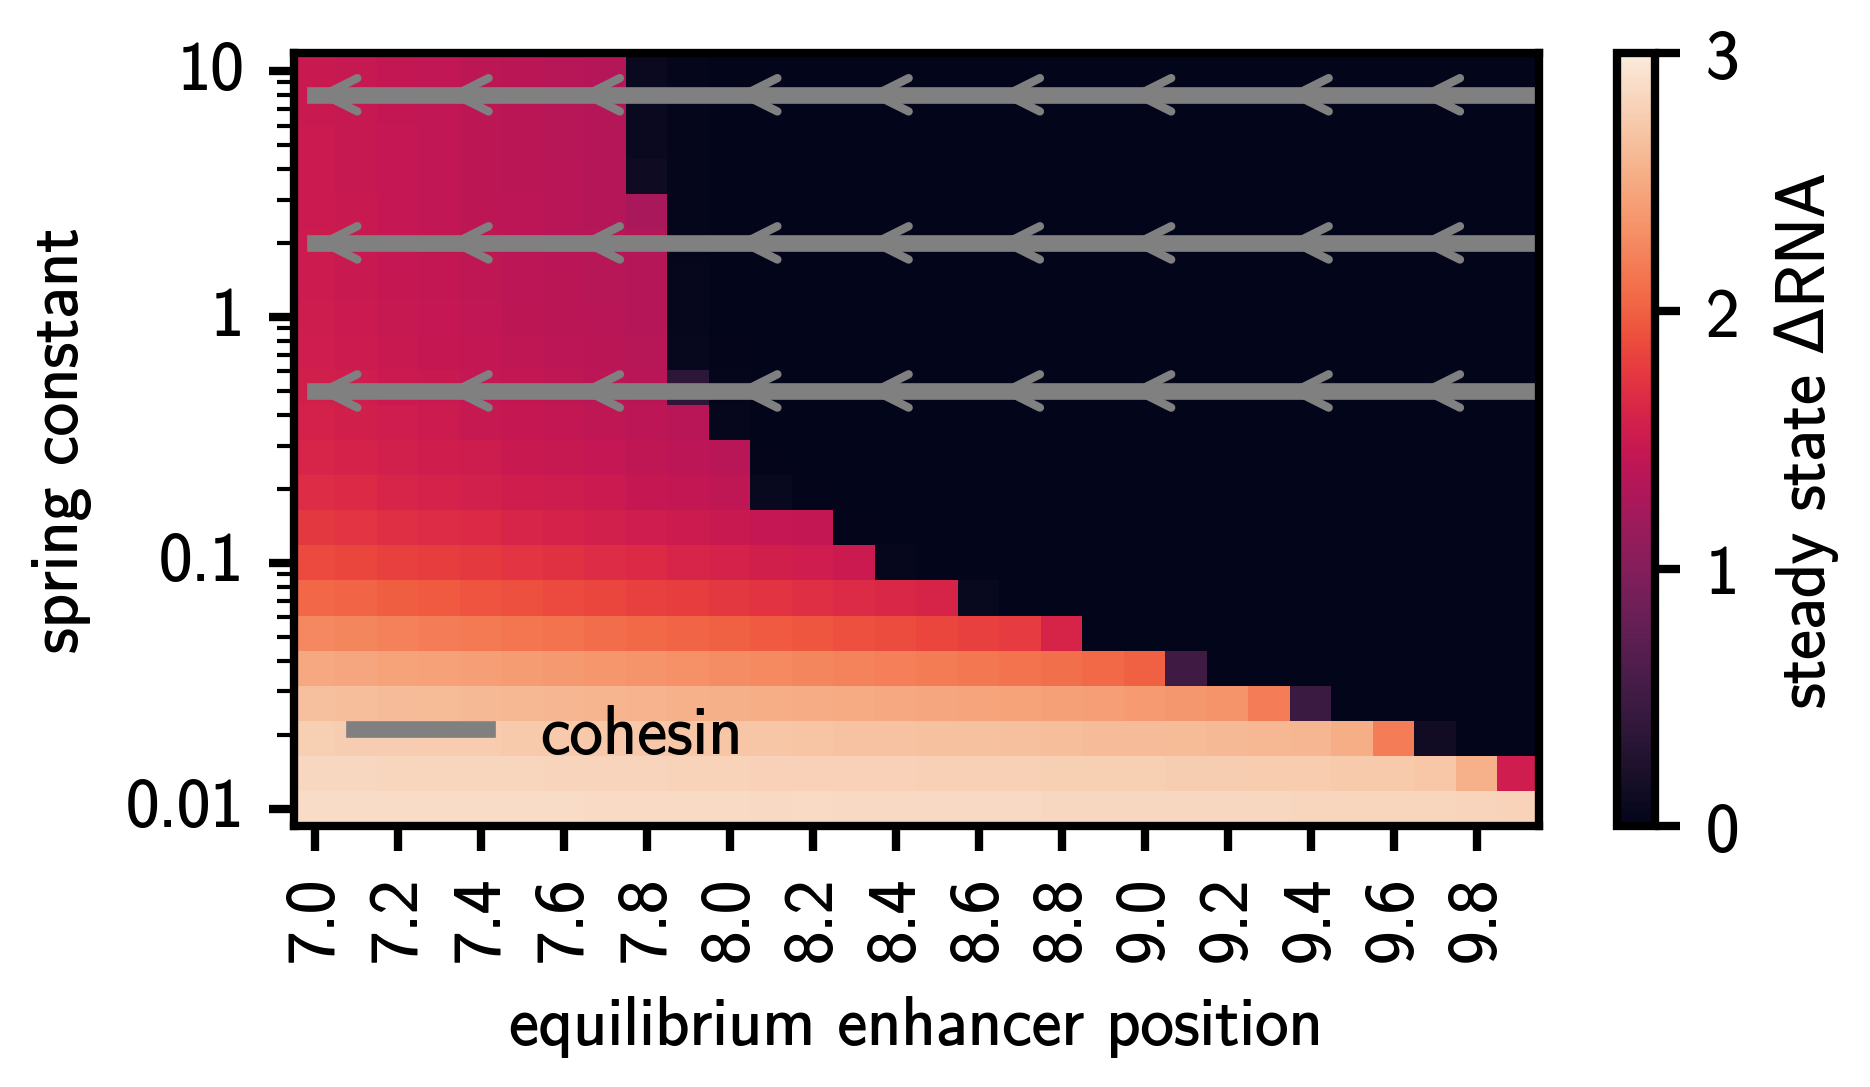

In [7]:
variable="rna_amount"
xlabel="equilibrium enhancer position"
ylabel="spring constant"
cbarlabel='steady state $\Delta$RNA'

fig, ax = plt.subplots()
scale = 0.7
# fig.set_size_inches(get_size_inches(scale,scale*2/3))
fig.set_size_inches(get_size_inches(1,2/4))
pivot = spd.df.pivot(index="k_tilde",columns="rest_length",values=variable)
g = sns.heatmap(pivot-no_condensate_rna, ax = ax,
            cbar_kws={'label': cbarlabel},
            vmin=0,vmax=3)
ax.invert_yaxis()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
for spine in ax.spines:
    ax.spines[spine].set_visible(True)

cb = ax.collections[0].colorbar
cb.outline.set_color('black')
cb.outline.set_linewidth(1)

for c in np.logspace(np.log10(0.5),np.log10(8),3):
    line_x = np.linspace(7,10.1)
    line_y = c/np.ones(np.shape(line_x))**2

    x_min, x_max = pivot.columns.min(), pivot.columns.max()
    mapped_x = (line_x - x_min) / (x_max - x_min) * (len(pivot.columns) - 1)+0.5

    # Map y coordinates (logarithmic scale)
    y_min, y_max = np.log(pivot.index.min()), np.log(pivot.index.max())
    mapped_y = (np.log(line_y) - y_min) / (y_max - y_min) * (len(pivot.index) - 1)+0.5
    # "Cohesin isotherm\n"r"$k\propto \frac{1}{R_0^2}$"
    line, = ax.plot(mapped_x,mapped_y,color="grey",label="cohesin")
    plot.add_arrow(line,direction='left',size=10)

def map_y(y):
    return (np.log(y) - y_min) / (y_max - y_min) * (len(pivot.index) - 1)+0.5

ax.yaxis.set_minor_locator(ticker.FixedLocator(map_y(generate_linlog_sequence(0.01,10))))
ax.set_yticks(map_y(np.array([0.01,0.1,1,10])))
# ax.set_yticklabels([f"$10^{{{i}}}$" for i in [-2,-1,0,1]])
ax.set_yticklabels([10**i for i in [-2,-1,0,1]])
ax.legend([label if i==0 else '_' for i, label in enumerate(ax.get_legend_handles_labels()[1])],
          loc="lower left")
plt.savefig(_FIGURE_DIR / "Fig2_B_TranscriptionEnhancement")

In [28]:
def frameFigure(sim,
                   i:int,
                   t:int):
    fig,ax = plt.subplots()
    cs = ax.tricontourf(sim.geometry.mesh.x,
                        sim.geometry.mesh.y,
                        sim.concentration_profile[i][t],
                        vmin = 3.5,
                        vmax = 5,
                        cmap=sim.movie_params['color_map'][i])
    ax.autoscale_view()
    ax.xaxis.set_tick_params(labelbottom=False, bottom=False)
    ax.yaxis.set_tick_params(labelleft=False, left=False)
    ax.set_aspect('equal', 'box')
    plt.setp(ax.spines.values(), visible=False)
    return fig,ax

,step,,dt,c_0_avg,c_0_min,c_0_max,c_1_avg,c_1_min,c_1_max,residuals,max_rate_of_change,free_energy,well_center_x,well_center_y,eqn3_potential,eqn3_spring,delay_head
0,0,0.000000,0.000010,3.564981,3.512900,5.516550,2.000000e-07,0.00000,0.000004,0.077721,0.052219,-23.939749,8.500000,-1.000000e-08,-0.000700,0.000000e+00,NaN
1,10,0.000159,0.000026,3.564981,3.448192,5.571088,3.640000e-06,0.00000,0.000065,0.003865,0.021670,-26.972279,8.500000,-2.000000e-07,-0.000699,0.000000e+00,NaN
2,20,0.000573,0.000067,3.564981,3.437248,5.554409,1.256000e-05,0.00000,0.000226,0.003018,0.015101,-28.750027,8.500000,-7.000000e-07,-0.000696,1.000000e-08,NaN
3,30,0.001645,0.000175,3.564981,3.440235,5.536609,3.568000e-05,0.00000,0.000641,0.003196,0.013325,-30.217546,8.499999,-2.000000e-06,-0.000694,4.000000e-08,NaN
4,40,0.004426,0.000453,3.564981,3.436192,5.517189,9.553000e-05,0.00000,0.001716,0.003654,0.011428,-31.672018,8.499997,-5.350000e-06,-0.000690,1.100000e-07,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,1160,5161.545376,5.000000,3.564981,3.499087,5.072061,1.974853e-02,0.00001,0.281713,0.000000,0.000000,-44.076821,8.395094,2.000000e-08,-0.003317,3.317420e-03,NaN
117,1170,5211.545376,5.000000,3.564981,3.499087,5.072061,1.974853e-02,0.00001,0.281713,0.000000,0.000000,-44.076821,8.395094,2.000000e-08,-0.003317,3.317420e-03,NaN
118,1180,5261.545376,5.000000,3.564981,3.499087,5.072061,1.974853e-02,0.00001,0.281713,0.000000,0.000000,-44.076821,8.395094,2.000000e-08,-0.003317,3.317420e-03,NaN
119,1190,5311.545376,5.000000,3.564981,3.499087,5.072061,1.974853e-02,0.00001,0.281713,0.000000,0.000000,-44.076821,8.395094,2.000000e-08,-0.003317,3.317420e-03,NaN


In [13]:
sim = simDir("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/04_CoupledFlow/20240702_PhaseDiagramSpringVsRestLengthCondensateMovesSeed_Longer/M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_0.1_c1_3.53_sw_1.0_sr_2.5_cn_5.5_l_8.5_M3_0.1_kt_0.316228_rl_8.5_wd_1.0_t_0.0_kd_1.0")
sim.run()
colspecs = [(i*20,(i+1)*20) for i in range(17)] 
enhancer_r = pd.read_fwf(sim.directory/"stats.txt", colspecs=colspecs)["well_center_x"].iloc[-1]
fig, ax = frameFigure(sim,i=0,t=-1)
ax.set_ylim(-5,5)
ax.set_xlim(left=-4,right=14)
ax.scatter(x=0, y=0, s=600, color='green',marker=".")
ax.scatter(x=10, y=0, s=600, color='black',marker=".")
ax.scatter(x=enhancer_r, y=0, s=600, color='#08306b',marker=".")
fig.savefig(_FIGURE_DIR/"Fig2_C_Right")

NameError: name 'frameFigure' is not defined

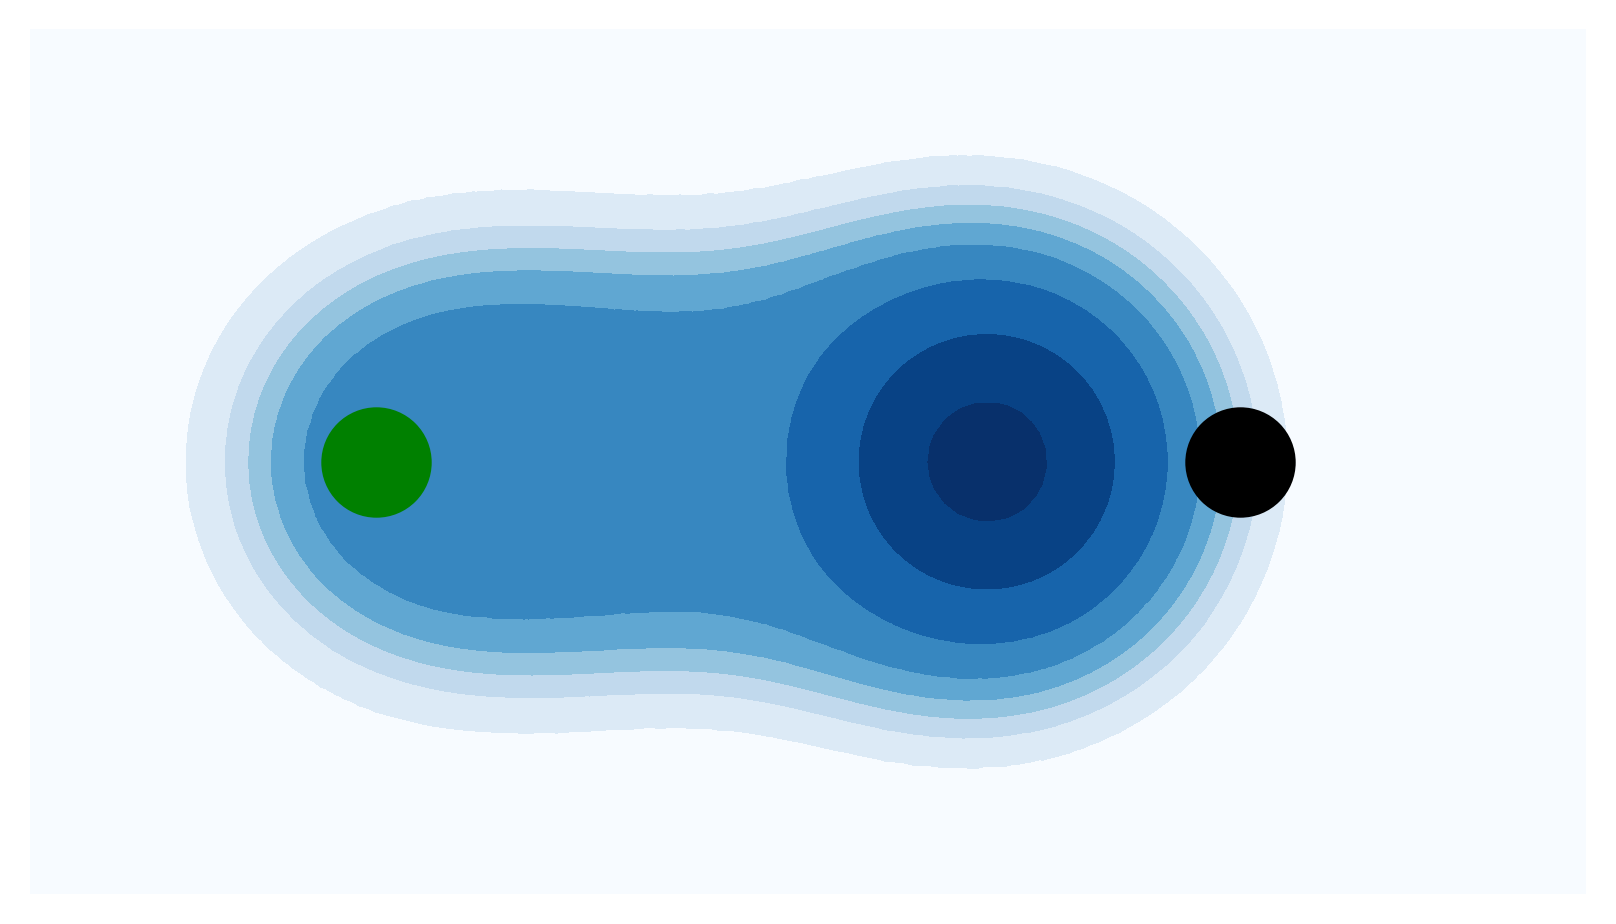

In [ ]:
sim = simDir("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/04_CoupledFlow/20240702_PhaseDiagramSpringVsRestLengthCondensateMovesSeed_Longer/M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_0.1_c1_3.53_sw_1.0_sr_2.5_cn_5.5_l_7.5_M3_0.1_kt_0.316228_rl_7.5_wd_1.0_t_0.0_kd_1.0")
sim.run()
colspecs = [(i*20,(i+1)*20) for i in range(17)] 
enhancer_r = pd.read_fwf(sim.directory/"stats.txt", colspecs=colspecs)["well_center_x"].iloc[-1]
fig, ax = frameFigure(sim, i=0,t=-1)
ax.set_ylim(-5,5)
ax.set_xlim(left=-4,right=14)
ax.scatter(x=0, y=0, s=600, color='green',marker=".")
ax.scatter(x=10, y=0, s=600, color='black',marker=".")
ax.scatter(x=enhancer_r, y=0, s=600, color='#08306b',marker=".")
fig.savefig(_FIGURE_DIR/"Fig2_C_Pinch")

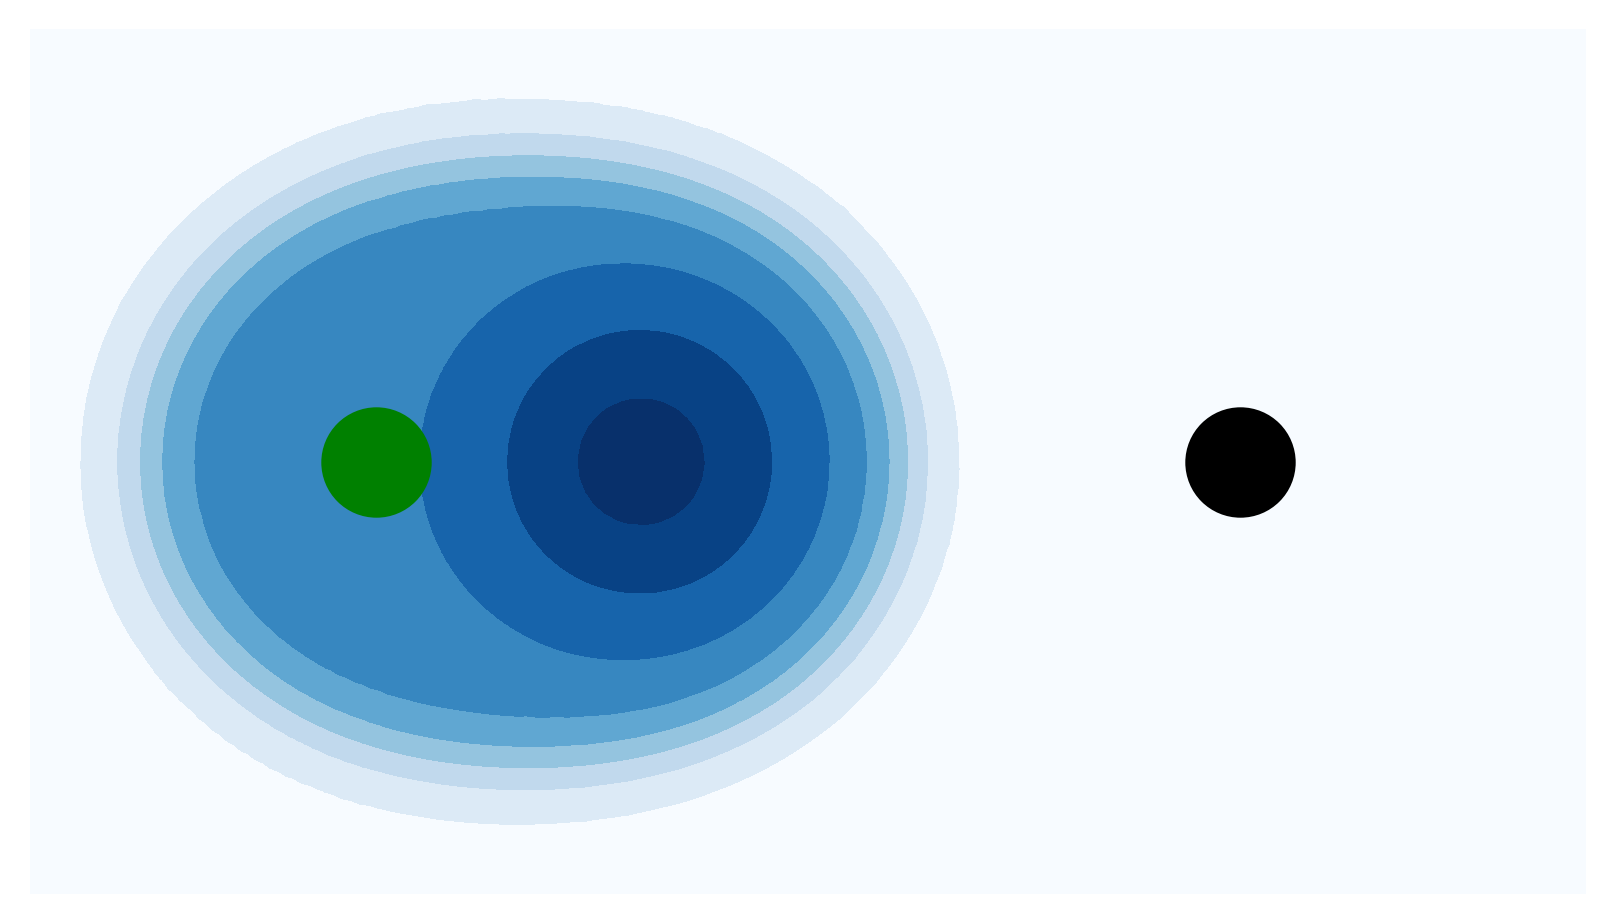

In [ ]:
sim = simDir("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/04_CoupledFlow/20240702_PhaseDiagramSpringVsRestLengthCondensateMovesSeed_Longer/M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_0.1_c1_3.53_sw_1.0_sr_2.5_cn_5.5_l_3.5_M3_0.1_kt_0.316228_rl_3.5_wd_1.0_t_0.0_kd_1.0")
sim.run()
colspecs = [(i*20,(i+1)*20) for i in range(17)] 
enhancer_r = pd.read_fwf(sim.directory/"stats.txt", colspecs=colspecs)["well_center_x"].iloc[-1]
fig, ax = frameFigure(sim, i=0,t=-1)
ax.set_ylim(-5,5)
ax.set_xlim(left=-4,right=14)
ax.scatter(x=0, y=0, s=600, color='green',marker=".")
ax.scatter(x=10, y=0, s=600, color='black',marker=".")
ax.scatter(x=enhancer_r, y=0, s=600, color='#08306b',marker=".")
fig.savefig(_FIGURE_DIR/"Fig2_C_Left")

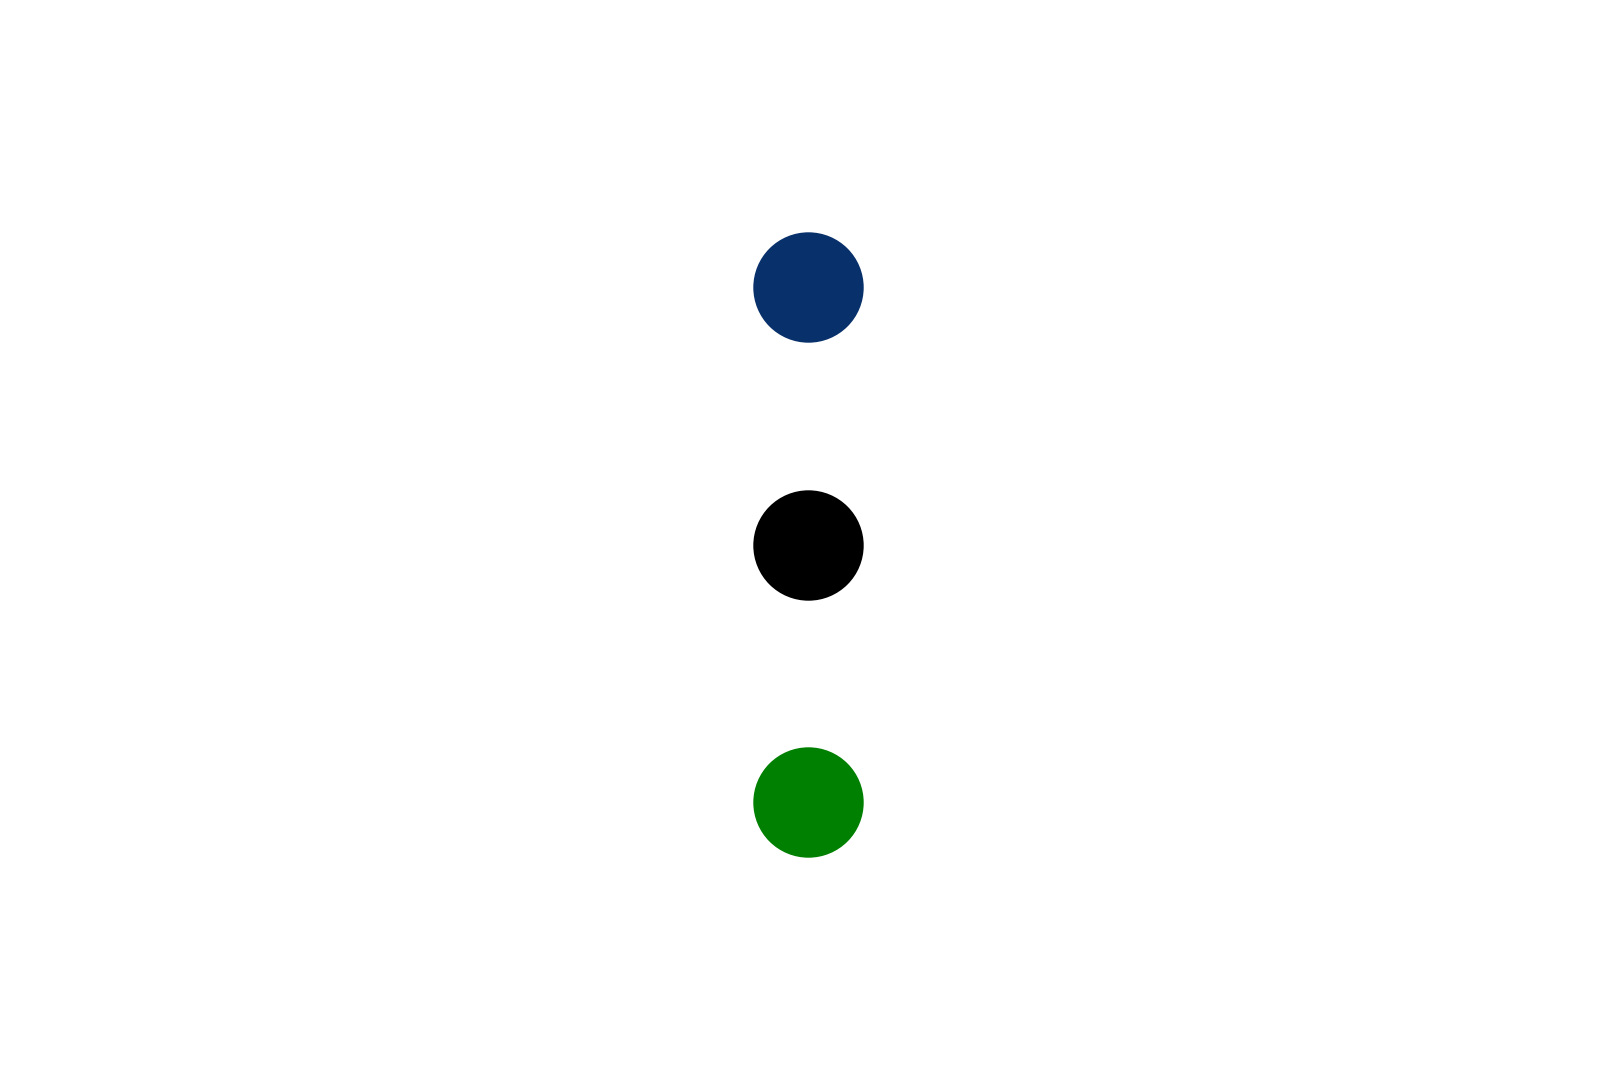

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x=0, y=0, s=600, color='green',marker=".")
ax.scatter(x=0, y=100, s=600, color='black',marker=".")
ax.scatter(x=0, y=200, s=600, color='#08306b',marker=".")
ax.set_ylim(-100,300)
ax.axis('off')
fig.savefig(_FIGURE_DIR/"Fig2_C_Legend")